In [1]:
import pandas as pd
import numpy as np
import pyodbc  
from datetime import datetime 
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
import seaborn as sns
import collections
import warnings
warnings.filterwarnings('ignore')

In [2]:
conn = pyodbc.connect("Driver={ODBC Driver 13 for SQL Server};Server=yetidb01.database.windows.net;database=YETISQLDW01;uid=htian;PWD=HeLeNtIAn52!")
cursor = conn.cursor()

In [3]:
df = pd.read_sql("SELECT S.CustomerID, C.Customer, S.OrderDate, S.Requested_Date, S.SalesOffice, S.OrderQty, P.ProductCategory, P.MasterSKU,S.sourcesystem FROM EDW_DS.ORDERFCT S  inner join [EDW].[PRODUCT_DIM] P ON P.ProductID = S.ProductID  left join EDW_DS.CUSTOMER_DIM C on S.CustomerID = C.CustomerID WHERE P.ISCORE = 'TRUE' and S.SalesOffice in ('STD','HYB')  and S.RejectionReason is null and S.Ordertype Not in ('ZARF','ZARM','ZEG2','ZERF','ZERM','ZRE') and S.SoldtoParty not in ('91860','0000107894','0000114883','0000108654')", conn)


In [4]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])  

In [5]:
df['Requested_Date'] = pd.to_datetime(df['Requested_Date'])  

In [6]:
df.isnull().sum()

CustomerID           0
Customer             0
OrderDate            0
Requested_Date     127
SalesOffice          0
OrderQty             0
ProductCategory      0
MasterSKU            0
sourcesystem         0
dtype: int64

In [7]:
df=df.fillna(0)

In [8]:
# 4% Requested_Date earlier than OrderDate
Date = []
for i in range(len(df)):
    if df.Requested_Date.iloc[i]==0: 
        Date.append(df.OrderDate.iloc[i])
    elif df.OrderDate.iloc[i]>df.Requested_Date.iloc[i]:
        Date.append(df.OrderDate.iloc[i])
    else:
        Date.append(df.Requested_Date.iloc[i])
df['Date']=Date

In [9]:
df=df[['CustomerID','Date', 'SalesOffice', 'OrderQty', 'ProductCategory', 'MasterSKU']]

In [10]:
df=df[(df.Date>='2014-01-01')&(df.Date<='2018-05-31')]

In [11]:
df.head()

,CustomerID,Date,SalesOffice,OrderQty,ProductCategory,MasterSKU
0,104504,2015-12-05,STD,2,Soft Cooler,Hopper 20
1,106068,2017-04-03,STD,48,Drinkware,R20 Tumbler
2,100822,2016-08-24,STD,4,Hard Cooler,Tundra 75
3,102559,2015-01-07,STD,1,Hard Cooler,Tundra 65
4,104274,2017-04-19,STD,1,Hard Cooler,Tundra 35


In [12]:
##################################################### Step one: age of each STD

In [13]:
age = df[['CustomerID','Date']].sort_values(by=["Date"])

In [14]:
age = age.drop_duplicates(subset='CustomerID')

In [15]:
age2=age.copy()
o=[str(x.year)+'-'+str(x.month) for x in age2.Date]
age2.Date=[datetime.strptime(x,'%Y-%m')for x in o] 

In [16]:
age2.head()

,CustomerID,Date
907202,101038,2014-01-01
708759,100256,2014-01-01
1137542,4167,2014-01-01
1825699,101426,2014-01-01
783108,101199,2014-01-01


In [17]:
end = pd.to_datetime(['2018-06-01']*len(age))

In [18]:
age2['end']=end

In [19]:
age2.head()

,CustomerID,Date,end
907202,101038,2014-01-01,2018-06-01
708759,100256,2014-01-01,2018-06-01
1137542,4167,2014-01-01,2018-06-01
1825699,101426,2014-01-01,2018-06-01
783108,101199,2014-01-01,2018-06-01


In [ ]:
# calculate the age of each STD

In [20]:
live = ((age2.end-age2.Date) / np.timedelta64(1, 'M')).astype(int)

In [21]:
age2['age']=live

In [22]:
age2.head()

,CustomerID,Date,end,age
907202,101038,2014-01-01,2018-06-01,52
708759,100256,2014-01-01,2018-06-01,52
1137542,4167,2014-01-01,2018-06-01,52
1825699,101426,2014-01-01,2018-06-01,52
783108,101199,2014-01-01,2018-06-01,52


In [23]:
########################################################### Step two: overall order_Qty

In [23]:
df1 = df['OrderQty'].groupby(df['CustomerID']).sum().to_frame(name='overall_Qty').reset_index()

In [24]:
df1 = df1.merge(age2[['CustomerID','age']],left_on='CustomerID', right_on='CustomerID', how='outer')

In [25]:
df1['avg_Qty'] = df1['overall_Qty']/df1['age']

In [26]:
df1 = df1.sort_values(by=["avg_Qty"],ascending=[False])

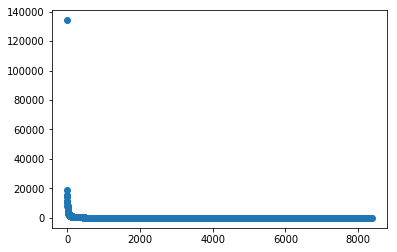

In [27]:
plt.scatter(range(len(df1)), df1.avg_Qty)

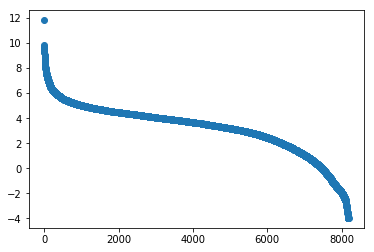

In [28]:
plt.scatter(range(len(df1)), np.log(df1.avg_Qty))

In [ ]:
# do k-means clustering, separate STD into 4 classes

In [29]:
X = np.array(df1.avg_Qty.iloc[1:].reshape(-1,1))
kmeans = KMeans(n_clusters = 4, random_state=0).fit(X)
kmeans.labels_

array([1, 1, 1, ..., 2, 2, 2])

In [30]:
Class=[]
Class.append(kmeans.labels_[0])
Class+=list(kmeans.labels_)

In [31]:
df1["Class"] = Class

Text(0.5,1,'Logarithmic Overall Order-Qty')

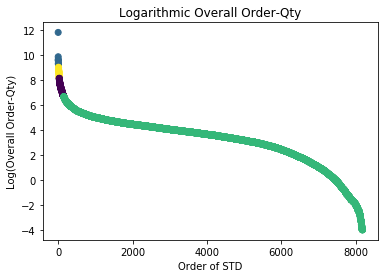

In [32]:
plt.scatter(range(len(df1)), np.log(df1.avg_Qty), c=df1.Class)
plt.xlabel('Order of STD')
plt.ylabel('Log(Overall Order-Qty)')
plt.title('Logarithmic Overall Order-Qty')

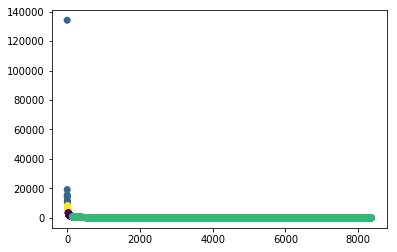

In [33]:
plt.scatter(range(len(df1)), df1.avg_Qty, c=df1.Class)

In [34]:
df1.head()

,CustomerID,overall_Qty,age,avg_Qty,Class
1580,101813,6302553,47,134096.872340,1
1806,102173,807267,42,19220.642857,1
630,100710,813606,52,15646.269231,1
1498,101711,759227,52,14600.519231,1
8119,5390,724538,52,13933.423077,1


In [35]:
len(df1[df1.Class==1])

9

In [36]:
len(df1[df1.Class==3])

20

In [37]:
len(df1[df1.Class==0])

121

In [38]:
len(df1[df1.Class==2])

8219

In [ ]:
# the label is not ordered, change the label to be 0,1,2,3

In [39]:
def ChangeLabel(res):
    df=res[0]
    cla=res[1]
    num = []
    n=len(cla)-1
    for item in cla:
        num.append(len(df[df.Class==item]))
    for i in range(len(num)):
        if i !=0:
            num[i]+=num[i-1]
    for i in range(len(num)):
        if i == 0:
            df.Class[:num[i]]=[n]*len(df.Class[:num[i]])
            n-=1
        else:
            df.Class[num[i-1]:num[i]] = [n]*len(df.Class[num[i-1]:num[i]])
            n-=1
    return df

In [40]:
def remove_duplicates(lst):
        return list(collections.OrderedDict(zip(lst, lst)).values())

In [41]:
ChangeLabel([df1,remove_duplicates(kmeans.labels_)]).head()

,CustomerID,overall_Qty,age,avg_Qty,Class
1580,101813,6302553,47,134096.872340,3
1806,102173,807267,42,19220.642857,3
630,100710,813606,52,15646.269231,3
1498,101711,759227,52,14600.519231,3
8119,5390,724538,52,13933.423077,3


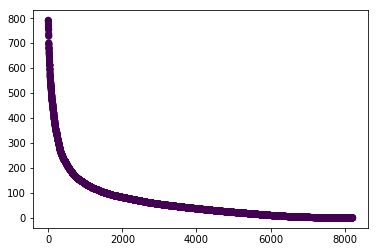

In [42]:
plt.scatter(range(len(df1[150:])), df1.avg_Qty[150:], c=df1.Class[150:])

In [43]:
# There is a long tail, # of <100 number are larger than 6000. We redo k-means clustering 

In [44]:
X1 = np.array(df1.avg_Qty[150:].reshape(-1,1))
kmeans1 = KMeans(n_clusters = 2, random_state=0).fit(X1)
kmeans1.labels_

array([1, 1, 1, ..., 0, 0, 0])

In [45]:
kmeans1.labels_

array([1, 1, 1, ..., 0, 0, 0])

In [46]:
df2=df1[150:]

In [47]:
Class1=[]
Class1+=list(kmeans1.labels_)
df2["Class1"] = Class1

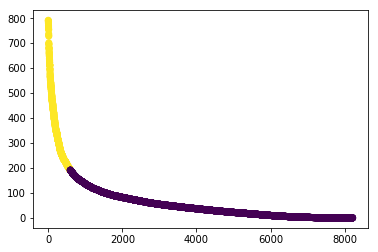

In [48]:
plt.scatter(range(len(df2)), df2.avg_Qty, c=df2.Class1)

In [49]:
len(df2[df2.Class1==0])

7626

In [50]:
len(df2[df2.Class1==1])

593

In [51]:
df1.Class[-7626:]=[4]*len(df1.Class[-7626:])

In [52]:
len(df1[df1.Class==3])

9

In [53]:
len(df1[df1.Class==2])

20

In [54]:
len(df1[df1.Class==1])

121

In [55]:
len(df1[df1.Class==0])

593

In [56]:
len(df1[df1.Class==4])

7626

In [61]:
ChangeLabel([df1,[3,2,1,0,4]]).head(20)

,CustomerID,overall_Qty,age,avg_Qty,Class
1580,101813,6302553,47,134096.872340,4
1806,102173,807267,42,19220.642857,4
630,100710,813606,52,15646.269231,4
1498,101711,759227,52,14600.519231,4
8119,5390,724538,52,13933.423077,4
2392,102853,575657,50,11513.140000,4
1586,101845,461325,43,10728.488372,4
5668,107894,182212,17,10718.352941,4
281,100315,544834,52,10477.576923,4
355,100395,433176,52,8330.307692,4


In [58]:
df1.head()

,CustomerID,overall_Qty,age,avg_Qty,Class
1580,101813,6302553,47,134096.872340,4
1806,102173,807267,42,19220.642857,4
630,100710,813606,52,15646.269231,4
1498,101711,759227,52,14600.519231,4
8119,5390,724538,52,13933.423077,4


Text(0.5,1,'Logarithmic Overall Order-Qty')

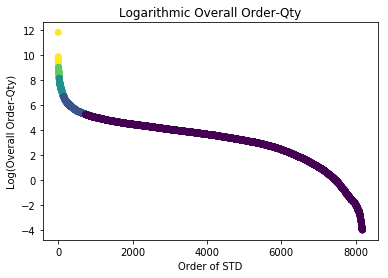

In [59]:
plt.scatter(range(len(df1)), np.log(df1.avg_Qty), c=df1.Class)
plt.xlabel('Order of STD')
plt.ylabel('Log(Overall Order-Qty)')
plt.title('Logarithmic Overall Order-Qty')

In [130]:
df1[['CustomerID','Class']].to_csv('Volume_OrderFct.csv')

# Check the segment result
Analysing diff percentage of product category in different Order_Qty STD

In [119]:
df8=df.copy()
o=[str(x.year)+'-'+str(x.month) for x in df.Date]
df8.Date=[datetime.strptime(x,'%Y-%m')for x in o] 

In [121]:
data = pd.merge(df8, df1[['CustomerID','Class']],  on='CustomerID', how='left')

In [122]:
data.head()

,CustomerID,Date,SalesOffice,OrderQty,ProductCategory,MasterSKU,Class
0,107397,2017-07-01,HYB,1,Hard Cooler,Tundra 105,2
1,106495,2017-07-01,STD,24,Drinkware,R20 Tumbler,1
2,104435,2015-06-01,STD,12,Drinkware,R30 Tumbler,0
3,101612,2015-08-01,STD,1,Soft Cooler,Hopper 20,0
4,106122,2017-04-01,STD,18,Drinkware,R Colsters,0


In [123]:
######################################################## Overall
dfO1 = data.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'OrderQty').reset_index()

dfO1.corr()

,Class,OrderQty
Class,1.000000,0.557116
OrderQty,0.557116,1.000000


In [124]:
######################################################## Drinkware
dfD = data[data.ProductCategory=='Drinkware']

dfD1 = dfD.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'DW_Qty').reset_index()

dfD1.corr()

,Class,DW_Qty
Class,1.000000,0.517298
DW_Qty,0.517298,1.000000


In [64]:
# average order quantity in different Class

In [125]:
dfD1.groupby(['Class'])['DW_Qty'].mean()

Class
0     22.451217
1     50.101651
2     92.304510
3    198.558858
4    697.808748
Name: DW_Qty, dtype: float64

In [126]:
######################################################## Hard Cooler
dfH = data[data.ProductCategory=='Hard Cooler']

dfH1 = dfH.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'HC_Qty').reset_index()

dfH1.corr()

,Class,HC_Qty
Class,1.000000,0.667224
HC_Qty,0.667224,1.000000


In [63]:
# average order quantity in different Class

In [127]:
dfH1.groupby(['Class'])['HC_Qty'].mean()

Class
0     1.783158
1     2.648206
2     3.977450
3     9.074612
4    15.180820
Name: HC_Qty, dtype: float64

In [128]:
######################################################## Soft Cooler
dfS = data[data.ProductCategory=='Soft Cooler']

dfS1 = dfS.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'SC_Qty').reset_index()

dfS1.corr()

,Class,SC_Qty
Class,1.000000,0.520095
SC_Qty,0.520095,1.000000


In [62]:
# average order quantity in different Class

In [129]:
dfS1.groupby(['Class'])['SC_Qty'].mean()

Class
0     2.993953
1     5.279671
2    10.036063
3    30.580786
4    47.528193
Name: SC_Qty, dtype: float64